So first we restore our variables that we stored in `nb1`.

In [1]:
%store -r

In [179]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell 
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


In [215]:
InteractiveShell.ast_node_interactivity = "all"
path = "../../csv/Mercedes-Benz Greener Manufacturing/"

In [233]:
def train_val_r2_score(estimator, n_splits=3, n_repeats=10, random_state=random_state):
    y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
    scores = np.array([])
    train_scores = np.array([])
    for i in tqdm(range(n_repeats)):
        kf = KFold(n_splits=n_splits, random_state=random_state+i, shuffle=True)
        y_train_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
        for train_index, val_index in kf.split(X_ohe):
            X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            _=estimator.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
            y_val_pred.iloc[val_index] = pd.DataFrame(estimator.predict(X_ohe_val.drop(drop_feat, axis=1)), index=val_index, columns=['y'])
            y_train_pred.iloc[train_index] += pd.DataFrame(estimator.predict(X_ohe_train.drop(drop_feat, axis=1)), index=train_index, columns=['y'])
        scores = np.append(scores, r2_score(y, y_val_pred))
        train_scores = np.append(train_scores, r2_score(y, y_train_pred/2))
    return scores, train_scores


So now we will try to find out which feature interactions are important from various importances that we calculated in `nb1`. 

In [7]:
var_df_ohe = pd.DataFrame(columns=['feature','variance'])
var_df_le = pd.DataFrame(columns=['feature','variance'])
for feat in tqdm(train_le.drop(['y','logy'], axis=1).columns):
    var_df_le.loc[var_df_le.shape[0],:] = list((feat, train_le[feat].var()))

for feat in tqdm(train_ohe.drop(['y','logy'], axis=1).columns):
    var_df_ohe.loc[var_df_ohe.shape[0],:] = list((feat, train_ohe[feat].var()))

var_df_ohe = var_df_ohe.sort_values(by='variance', axis=0).reset_index(drop=True)
var_df_le = var_df_le.sort_values(by='variance', axis=0).reset_index(drop=True)

100%|██████████| 507/507 [00:01<00:00, 286.14it/s]


Above we have calculated variance of each individual feature in both the encodings. This will help us in dropping features that have almost zero variance. From now on we will perform our analysis on one hot encoding and later we will check label encoding. 

Next we will try to find features which we can drop from our analysis

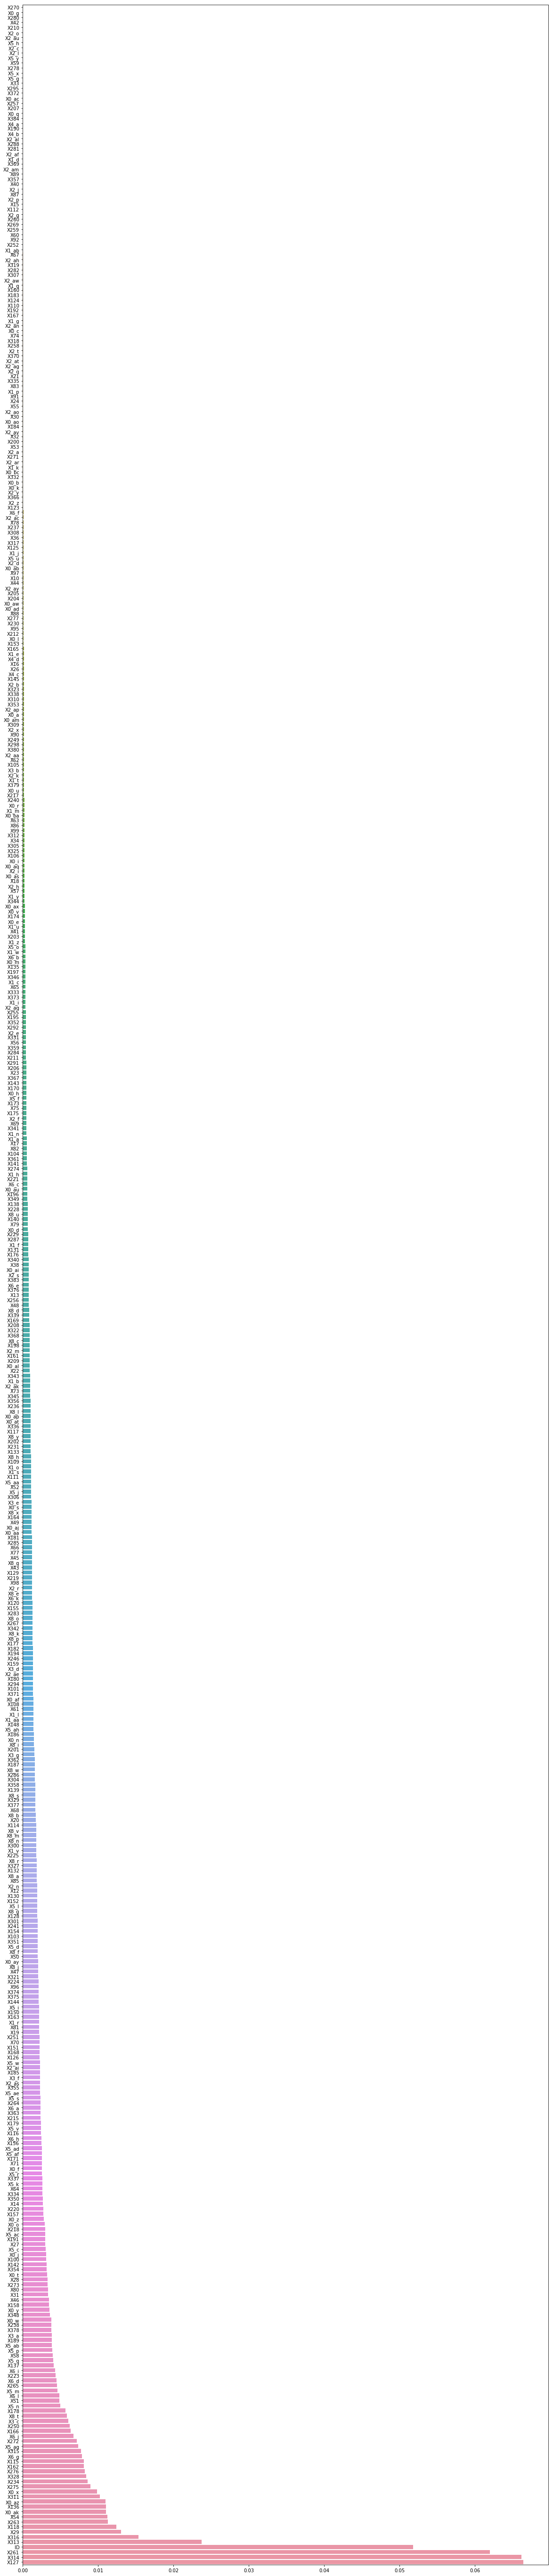

In [113]:
_,ax = plt.subplots(figsize=(20,100))
_=sns.barplot(x=list(feat_imp_ohe), y=list(feat_imp_ohe.index), ax=ax)


From above bar plot we can decide to drop features which have less importance. Let's add last 100 features to a list that we will drop. 

In [10]:
drop_feat_rf_ohe = []
drop_feat_rf_ohe.extend(list(feat_imp_ohe.index[:100]))

In [11]:
drop_feat_var_ohe = []
drop_feat_var_ohe.extend(list(var_df_ohe.iloc[:96].feature.values))

Here I have added those features to the list which have less than 10 ones in them and thus have a very low variance. 


In [12]:
drop_feat_anova = []
drop_feat_anova.extend(list(feat_imp_anova.loc[feat_imp_anova['p-value'] > 0.2, :].index))

Above we have added those features in removal list which have p-value > 0.2 which is quite a conservative p-value but it already covers more than 140 features. Let's now actually remove them one by one and see if we can get an improvement. 

First let's properly split our data into train and valid so that we get an honest estimate our test score. 

In [70]:
X_ohe = train_ohe.drop(['y','logy'], axis=1)
y = train_ohe['y']
logy = train_ohe['logy']
X_ohe_train, X_ohe_val, y_train, y_val = train_test_split(X_ohe, y, test_size=0.25, random_state=random_state+10)

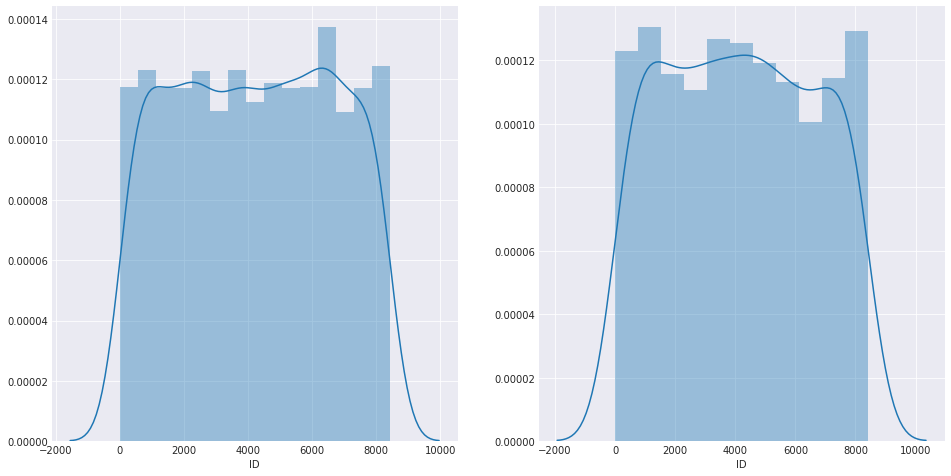

In [71]:
sns.set_style('darkgrid')
_,ax = plt.subplots(ncols=2, figsize=(16,8))
_=sns.distplot(X_ohe_train['ID'], ax=ax[0])
_=sns.distplot(X_ohe_val['ID'], ax=ax[1])

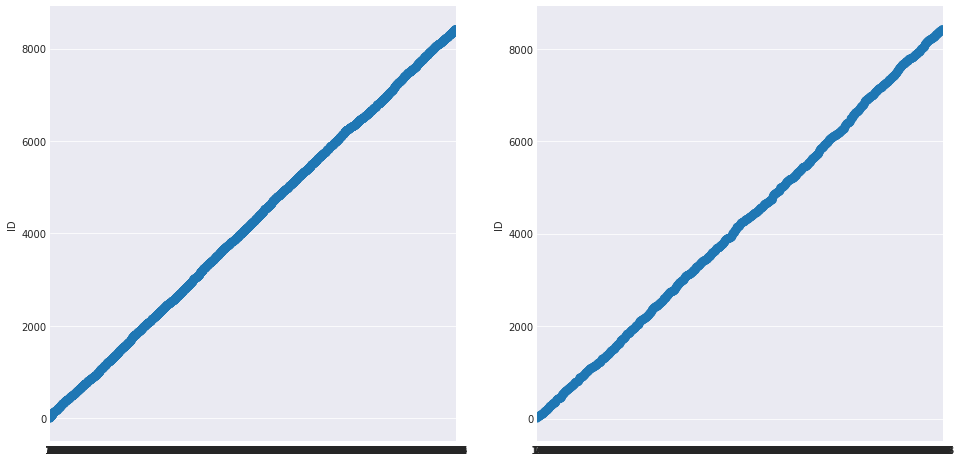

In [72]:
_,ax = plt.subplots(ncols=2, figsize=(16,8))
_=sns.pointplot(X_ohe_train.index.values, y=X_ohe_train.ID, ax=ax[0])
_=sns.pointplot(X_ohe_val.index.values, y=X_ohe_val.ID, ax=ax[1])

Here we can see that out train and validation have similar splitting as our train and test which we saw in last notebook.

In [23]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_rf_ohe, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_rf_ohe, axis=1))

In [24]:
print (r2_score(y_val, y_pred))

0.573185931356


In [31]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+1, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_anova, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_anova, axis=1))

In [32]:
print (r2_score(y_val, y_pred))

0.553080633174


In [39]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+1, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat_var_ohe, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat_var_ohe, axis=1))

In [40]:
print (r2_score(y_val, y_pred))

0.570364124214


Now there seems to be some improvement in our `r2_score` by removing irrelevant features.So next we can try to merge the features in the 3 lists but first let's try to make a list of very important features from `feat_imp_ohe` so that we don't accidently drop any of the important feature. 


In [41]:
must_include_feat = list(feat_imp_ohe[-100:].index)
drop_feat = list(set(drop_feat_anova+drop_feat_rf_ohe+drop_feat_var_ohe))
drop_feat = [f for f in drop_feat if f not in must_include_feat]
len(drop_feat)

187

So overall we have shortlisted 187 features that we intend to drop from our model. Let's try random forest without these features. 

In [48]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state+1, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
y_pred = rf.predict(X_ohe_val.drop(drop_feat, axis=1))

In [49]:
print (r2_score(y_val, y_pred))

0.573761110922


Not much of improvement. :/ Anyway let's make a submission by training our model on full data. 

In [282]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe.drop(drop_feat, axis=1), y)
y_pred = rf.predict(test_ohe.drop(drop_feat, axis=1))

In [288]:
subm = np.stack((test_ohe.ID.values, np.round(y_pred,5)), axis=1)
np.savetxt(path+'subm1.csv', subm, delimiter=',',header='ID,y', comments='', fmt=['%d','%.5f'])

The score on kaggle leaderboard is 0.537. Also if we train our random forest model on full data we have same r2 score on validation as we see in next cells. 

In [57]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe_train, y_train)
y_pred = rf.predict(X_ohe_val)

In [58]:
print (r2_score(y_val, y_pred))

0.570456216929


Okay, So we saw there hasn't been much difference with or without dropping features. Also we see that there is difference between our scores and kaggle scores. So first lets fix that otherwise it is like blind experiment. 
First let's create a validation set whose r2 score we can trust. 

In [89]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=random_state)
cv_scores = cross_val_score(rf, X_ohe.drop(drop_feat, axis=1), y, cv=rkf, scoring='r2', n_jobs=-1)

In [92]:
cv_scores
cv_scores.std()
cv_scores.mean()

array([ 0.56707998,  0.53732899,  0.47411993,  0.54104993,  0.49531778,
        0.48241309,  0.50276032,  0.5004392 ,  0.53491152,  0.54277733,
        0.51143453,  0.513354  ,  0.58217038,  0.52755252,  0.4692895 ,
        0.46335293,  0.53793596,  0.55436884,  0.4600489 ,  0.54641549,
        0.54892853,  0.52900609,  0.53355275,  0.48977692,  0.51384895,
        0.52237338,  0.53518382,  0.5798326 ,  0.50960959,  0.47051461])

0.032929554669350825

0.51922494592349078

Here mean of `cv_scores` is close to what I have been been receving of leaderboard, but here also I have a standaed deviation of `0.032` which can make or break fortunes on kaggle. So assuming that our r2 score follows a normal distribution we can say with 68% confidence that out validation score will be somewhere between 0.487 to 0.551. Well that isn't very encouraging. 

Okay let's try to deduce r2 score from stacked predictions and see if we can reduce our standard deviation. 

In [149]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
rkf = RepeatedKFold(n_splits=3, n_repeats=10, random_state=random_state)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
y_test_pred = pd.DataFrame(data=np.zeros(shape=(test_ohe.shape[0])),index=test_ohe.index, columns=['y'])
scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train, y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val), index=val_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))


100%|██████████| 10/10 [03:18<00:00, 19.87s/it]


In [152]:
scores
scores.std()
scores.mean()

array([ 0.52126306,  0.50953   ,  0.52007177,  0.50858428,  0.52467782,
        0.50616617,  0.51632671,  0.51659848,  0.51896283,  0.51158769])

0.0058135245480252064

0.51537687888973494

So here we have stacked our predictions from each fold and repeated it 10 times. As we see our standard deviation for r2 score has considerably decreased from 0.03 to 0.005 . Althoug after looking at leaderboard it still seems too much. Anyway first let's submit this model's prediction on test set. Later we can try adversarial validation to reduce our variation in r2 score. 

In [ ]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
_=rf.fit(X_ohe, y)
y_test_pred = rf.predict(test_ohe)

In [156]:
np.savetxt(path+'subm0.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d', '%.8f'), delimiter=',',header='ID,y', comments='')

Okay so the results are exactly same as previous submission(because the models were exactly same) but at least we got our validation somewhat correct. If required we can try adversarial validation scheme. 

So now let's try to drop our irrelevant features and see if we can get an improvement. 

In [163]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train.drop(drop_feat_rf_ohe, axis=1), y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val.drop(drop_feat_rf_ohe, axis=1)), index=val_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))


100%|██████████| 10/10 [02:58<00:00, 17.82s/it]


In [164]:
scores
scores.std()
scores.mean()

array([ 0.52469023,  0.51038952,  0.52000114,  0.50992585,  0.52200599,
        0.50639532,  0.51714096,  0.51761645,  0.51849099,  0.51459845])

0.0054785986180002928

0.51612549209338554

In [165]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val.drop(drop_feat, axis=1)), index=val_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))


100%|██████████| 10/10 [03:21<00:00, 20.10s/it]


In [166]:
scores
scores.std()
scores.mean()

array([ 0.52328868,  0.51041776,  0.51995618,  0.50923922,  0.52227604,
        0.50803654,  0.51855599,  0.5189743 ,  0.51815384,  0.51493462])

0.0051781803028865181

0.51638331463503762

So in previous cells we have slightly improved our r2 score and compared to the one we submitted. Although standard deviation suggests that this tiny improvement could have been by chance. Anyway let's submit the predictions from both the models and see. 

In [169]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1, max_features='sqrt')
_=rf.fit(X_ohe.drop(drop_feat_rf_ohe, axis=1), y)
y_test_pred = rf.predict(test_ohe.drop(drop_feat_rf_ohe, axis=1))

In [171]:
np.savetxt(path+'subm1.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d', '%.6f'), header='ID,y', comments='', delimiter=',')

In [172]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1, max_features='sqrt')
_=rf.fit(X_ohe.drop(drop_feat, axis=1), y)
y_test_pred = rf.predict(test_ohe.drop(drop_feat, axis=1))

In [173]:
np.savetxt(path+'subm2.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d', '%.6f'), header='ID,y', comments='', delimiter=',')

Submitting `subm1` and `subm2` ended up having better scores and that validates our cross validation strategy. Also we will follow our own CV scores and submit the ones where our r2 score increases. 

Next let's try to tune hyperparameters like max_depth, max_features of our RandomForest model.

In [189]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1, max_depth=8)
y_val_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
scores = np.array([])
train_scores = np.array([])
for i in tqdm(range(10)):
    kf = KFold(n_splits=3, random_state=random_state+i, shuffle=True)
    y_train_pred = pd.DataFrame(data=np.zeros(shape=(X_ohe.shape[0])),index=X_ohe.index, columns=['y'])
    for train_index, val_index in kf.split(X_ohe):
        X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        _=rf.fit(X_ohe_train.drop(drop_feat, axis=1), y_train)
        y_val_pred.iloc[val_index] = pd.DataFrame(rf.predict(X_ohe_val.drop(drop_feat, axis=1)), index=val_index, columns=['y'])
        y_train_pred.iloc[train_index] += pd.DataFrame(rf.predict(X_ohe_train.drop(drop_feat, axis=1)), index=train_index, columns=['y'])
    scores = np.append(scores, r2_score(y, y_val_pred))
    train_scores = np.append(train_scores, r2_score(y, y_train_pred/2))


100%|██████████| 10/10 [01:08<00:00,  6.83s/it]


In [190]:
scores
scores.std()
scores.mean()

train_scores
train_scores.std()
train_scores.mean()


array([ 0.54626595,  0.53802012,  0.54256989,  0.53682318,  0.54471775,
        0.53733475,  0.5447338 ,  0.54323792,  0.54162956,  0.53888661])

0.0032528105668075428

0.54142195320354003

array([ 0.624358  ,  0.62114289,  0.6208711 ,  0.62363008,  0.62126363,
        0.6240419 ,  0.62112681,  0.62242681,  0.61871165,  0.62194153])

0.0016332702277625641

0.62195144182585349

Lowering `max_depth` parameter in Random Forest model has surely improved results but let's find out the optimal value for `max_depth`. 

In [210]:
depths = [7,10,14,20]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(depths),n_repeats))
train_scores = np.empty(shape=(len(depths),n_repeats))
for i in tqdm(range(len(depths))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1, max_depth=depths[i])
    scores = train_val_r2_score(rf, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 4/4 [07:15<00:00, 108.88s/it]


In [212]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.53419057,  0.54785482,  0.54449841,  0.52989386])

array([ 0.00292482,  0.0037149 ,  0.00468874,  0.00495419])

array([ 0.59154402,  0.68166367,  0.78936023,  0.88914992])

array([ 0.00100826,  0.00109515,  0.00137449,  0.00095956])

Let's search more finer. 

In [213]:
depths = [9,10,12,13]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(depths),n_repeats))
train_scores = np.empty(shape=(len(depths),n_repeats))
for i in tqdm(range(len(depths))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features='sqrt', n_jobs=-1, max_depth=depths[i])
    scores = train_val_r2_score(rf, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 4/4 [06:10<00:00, 92.60s/it]


In [216]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.5464713 ,  0.54784952,  0.54782139,  0.54646169])

array([ 0.00339771,  0.00372271,  0.00394441,  0.00423574])

array([ 0.65265874,  0.68166401,  0.73936277,  0.76568685])

array([ 0.00172162,  0.00109486,  0.00096908,  0.0016723 ])

Looks like max_depth=10 is the optimal choice. Now let's tune max_features. 

In [237]:
features = [11, 14, 18, 24]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(features),n_repeats))
train_scores = np.empty(shape=(len(features),n_repeats))
for i in tqdm(range(len(features))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features=features[i], n_jobs=-1, max_depth=10)
    scores = train_val_r2_score(rf, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 4/4 [06:02<00:00, 90.64s/it]


In [238]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.53418758,  0.54364439,  0.54897413,  0.55359198])

array([ 0.0028894 ,  0.00293359,  0.00372951,  0.00411803])

array([ 0.65060869,  0.66873353,  0.68577367,  0.70294461])

array([ 0.00148938,  0.00168451,  0.00150092,  0.0015965 ])

So let's tune more as our optimal value is a corner value. 

In [241]:
features = [35, 40, 50]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(features),n_repeats))
train_scores = np.empty(shape=(len(features),n_repeats))
for i in tqdm(range(len(features))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features=features[i], n_jobs=-1, max_depth=10)
    scores = train_val_r2_score(rf, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 3/3 [10:02<00:00, 200.86s/it]


In [242]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.5561638 ,  0.55659849,  0.55635104])

array([ 0.0045554 ,  0.00455789,  0.00484248])

array([ 0.71996502,  0.72563362,  0.73231312])

array([ 0.00063284,  0.00123143,  0.00169095])

max_features=40 gives best result. Let's finetune around this value. 

In [243]:
features = [38, 42, 46]
n_splits= 3
n_repeats = 10
val_scores = np.empty(shape=(len(features),n_repeats))
train_scores = np.empty(shape=(len(features),n_repeats))
for i in tqdm(range(len(features))):
    rf = RandomForestRegressor(n_estimators=300, random_state=random_state, max_features=features[i], n_jobs=-1, max_depth=10)
    scores = train_val_r2_score(rf, n_splits=n_splits, n_repeats=n_repeats)
    val_scores[i] = scores[0]
    train_scores[i] = scores[1]

100%|██████████| 3/3 [06:49<00:00, 136.59s/it]


In [244]:
val_scores.mean(axis=1)
val_scores.std(axis=1)
train_scores.mean(axis=1)
train_scores.std(axis=1)

array([ 0.556717  ,  0.55670292,  0.55656661])

array([ 0.00438882,  0.00482327,  0.00482623])

array([ 0.72326399,  0.72654537,  0.72897558])

array([ 0.00163706,  0.00131195,  0.00219448])

So let's use max_features=38 or any other close by value since the results vary a bit. 

Finally we have max_depth=10 and max_features=38. Let's fit a model and submit. 

In [245]:
rf = RandomForestRegressor(n_estimators=300, random_state=random_state, n_jobs=-1, max_features=38, max_depth=10)
_=rf.fit(X_ohe.drop(drop_feat, axis=1), y)
y_test_pred = rf.predict(test_ohe.drop(drop_feat, axis=1))

In [248]:
np.savetxt(path+'subm3.csv', np.stack((test_ohe.ID.values, y_test_pred), axis=1), fmt=('%d','%.6f'), delimiter=','
          , header='ID,y', comments='')

This submission significantly increases our r2 score on kaggle to 0.56237 on public LB and 0.54489 on private LB. 

Next we will try to figure out frequent feature interactions and try to construct new features. 